In [2]:
import pandas as pd
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import itertools
import math
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras import models, layers, callbacks, optimizers
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
# 그래프 사이즈 지정
rcParams['figure.figsize'] = 15,10

## 데이터 준비

In [3]:
df = pd.read_csv('SPY_2011_22.csv')
df['Date'] = pd.to_datetime(df['Date'])  # datetime으로 변환
df1 = df.set_index('Date')  # Date를 인덱스로 지정

# 월별 예측

In [4]:
df_month = pd.DataFrame(df1['Close'].resample('BMS').first())  # y: 달의 첫날(BMS)의 종가로 지정
df1 = df1.reset_index()  # 다시 컬럼으로 변환
df_month = df_month.reset_index()
df_month = df_month.iloc[1:, :]  # 11년 1월을 예측할 데이터가 존재하지 않기 때문에 제외

In [5]:
x_list = []

In [6]:
# 모델을 만드는 목적: 전 월의 Close로 다음 월 첫 날의 Close를 예측한다.

# 모델 학습에 필요한 데이터 정제
# 매 월 15일간(15일~30일)의 데이터를 묶어준다. -> 묶어준 데이터들을 x_list에 넣어준다.
for i in range(2011, 2023):
    for j in range(1, 13):
        if j < 9:
            cond = (df1['Date'] >= (str(i) + '-' + str(0) + str(j))) & (
                        df1['Date'] < (str(i) + '-' + str(0) + str(j + 1)))
            x_list.append(df1.loc[cond]['Close'].values[-15:])
        elif j == 9:
            cond = (df1['Date'] >= (str(i) + '-' + str(0) + str(j))) & (df1['Date'] < (str(i) + '-' + str(j + 1)))
            x_list.append(df1.loc[cond]['Close'].values[-15:])
        elif j == 12:
            cond = (df1['Date'] >= (str(i) + '-' + str(j))) & (df1['Date'] < (str(i + 1) + '-' + str(0) + str(1)))
            x_list.append(df1.loc[cond]['Close'].values[-15:])
        else:
            cond = (df1['Date'] >= (str(i) + '-' + str(j))) & (df1['Date'] < (str(i) + '-' + str(j + 1)))
            x_list.append(df1.loc[cond]['Close'].values[-15:])

In [7]:
# x_list를 넘파이 배열로 변환
X = np.array(x_list)

In [8]:
X

array([[126.9800034, 127.4300003, 128.5800018, ..., 129.9900055,
        127.7200012, 128.6799927],
       [131.9700012, 132.5700073, 132.2700043, ..., 130.9299927,
        132.3300018, 133.1499939],
       [130.8399963, 130.0500031, 128.5599976, ..., 131.8600006,
        132.7700043, 132.5899963],
       ...,
       [357.7399902, 356.5599976, 365.9700012, ..., 379.980011 ,
        389.019989 , 386.2099915],
       [374.1300049, 394.6900024, 398.5100098, ..., 395.9100037,
        395.230011 , 407.6799927],
       [396.2399902, 393.2799988, 398.9500122, ..., 381.3999939,
        376.6600037, 383.4400024]])

In [9]:
y_list = []

In [10]:
# 매 월 첫 날의 데이터들을 y_list에 넣어준다.
for i in range(len(df_month['Close'].tolist())) :
    y_list.append(np.array([df_month['Close'].tolist()[i]]))

In [11]:
# y_list를 넘파이 배열로 변환
y = np.array(y_list)

In [12]:
y

array([[130.7400055],
       [130.9299927],
       [133.1499939],
       [136.2200012],
       [131.8699951],
       [133.9199982],
       [128.7799988],
       [120.9400024],
       [109.9300003],
       [122.       ],
       [124.9700012],
       [127.5      ],
       [132.4700012],
       [137.7299957],
       [141.8399963],
       [140.7400055],
       [128.1600037],
       [136.5099945],
       [137.5899963],
       [141.0299988],
       [144.3500061],
       [142.8300018],
       [141.4499969],
       [146.0599976],
       [151.2400055],
       [152.1100006],
       [156.0500031],
       [158.2799988],
       [164.3500061],
       [161.3600006],
       [170.6600037],
       [164.3899994],
       [169.3399963],
       [176.2100067],
       [180.5299988],
       [182.9199982],
       [174.1699982],
       [184.9799957],
       [188.25     ],
       [188.3300018],
       [192.8999939],
       [197.0299988],
       [192.5      ],
       [200.6100006],
       [194.3500061],
       [20

## 월별 LSTM

In [13]:
X1 = X[:-1]
# y에 2023년 1월 첫 날의 데이터가 없어서 x에서 2022년 12월 데이터를 삭제한 것이다.

In [17]:
# train_test_split: 데이터(시계열의 순서) 섞어주기
# 섞어주는 이유는 모델의 성능을 높이기 위해서
# 왜 시계열의 순서를 섞어줘야 되냐? 안 섞으면 원래 데이터랑 똑같잖아 그래서 새로운 데이터가 들어왔을 때 예측을 못하는 거지
# 그래서 섞어주면 모델의 성능이 높아진다는 말이야 (= 학습 데이터에 덜 맞추되 새로운 데이터에 덜 틀린다.)

# train과 test 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(X1, y, random_state = 42)

# random_state: 조건 맞춰주기
# 모든 학생들에게 같은 시험지를 주는 것과 같음 = 여기선 42 시험지

In [18]:
print(len(X_train), len(X_test))

107 36


In [22]:
x = layers.Input(shape=(X_train.shape[1], 1))
lstm = layers.LSTM(64)(x)
dense = layers.Dense(32)(lstm)
norm = layers.BatchNormalization()(dense)
relu = layers.ReLU()(norm)
y = layers.Dense(1)(relu)
model = models.Model(x, y)

model.compile('adam', 'mean_squared_error')  # loss function: mean_squared_error 사용

In [23]:
# EarlyStopping: val_loss가 제일 낮아도 Epoch 70번은 더 해봐라
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=100)

In [24]:
# 모델 학습
history = model.fit(X_train, y_train, epochs = 1000, validation_data = [X_test, y_test], batch_size = 16, verbose = 1, callbacks = es)

Epoch 1/1000
7/7 [==============================] - 4s 132ms/step - loss: 73568.9453 - val_loss: 65404.2070
Epoch 2/1000
7/7 [==============================] - 0s 17ms/step - loss: 73181.7578 - val_loss: 65350.4570
Epoch 3/1000
7/7 [==============================] - 0s 19ms/step - loss: 72962.1484 - val_loss: 65271.6172
Epoch 4/1000
7/7 [==============================] - 0s 17ms/step - loss: 72796.6172 - val_loss: 65212.6328
Epoch 5/1000
7/7 [==============================] - 0s 19ms/step - loss: 72649.8750 - val_loss: 65145.7344
Epoch 6/1000
7/7 [==============================] - 0s 17ms/step - loss: 72631.9688 - val_loss: 65080.6602
Epoch 7/1000
7/7 [==============================] - 0s 18ms/step - loss: 72448.5781 - val_loss: 65040.7656
Epoch 8/1000
7/7 [==============================] - 0s 19ms/step - loss: 72366.6328 - val_loss: 65001.3281
Epoch 9/1000
7/7 [==============================] - 0s 18ms/step - loss: 72231.6250 - val_loss: 64953.8555
Epoch 10/1000
7/7 [=================

Epoch 77/1000
7/7 [==============================] - 0s 20ms/step - loss: 59838.6445 - val_loss: 52503.9453
Epoch 78/1000
7/7 [==============================] - 0s 18ms/step - loss: 59404.9727 - val_loss: 55431.5820
Epoch 79/1000
7/7 [==============================] - 0s 19ms/step - loss: 59199.6211 - val_loss: 53026.0352
Epoch 80/1000
7/7 [==============================] - 0s 18ms/step - loss: 59091.2695 - val_loss: 53121.4570
Epoch 81/1000
7/7 [==============================] - 0s 17ms/step - loss: 58489.9961 - val_loss: 53602.7344
Epoch 82/1000
7/7 [==============================] - 0s 16ms/step - loss: 58054.9570 - val_loss: 51597.9766
Epoch 83/1000
7/7 [==============================] - 0s 14ms/step - loss: 57848.1523 - val_loss: 52532.5859
Epoch 84/1000
7/7 [==============================] - 0s 15ms/step - loss: 57987.2891 - val_loss: 51064.5078
Epoch 85/1000
7/7 [==============================] - 0s 17ms/step - loss: 57507.7227 - val_loss: 49734.2070
Epoch 86/1000
7/7 [=========

7/7 [==============================] - 0s 16ms/step - loss: 13892.1631 - val_loss: 11777.4385
Epoch 228/1000
7/7 [==============================] - 0s 14ms/step - loss: 15571.7637 - val_loss: 12521.5107
Epoch 229/1000
7/7 [==============================] - 0s 14ms/step - loss: 13290.3447 - val_loss: 10443.5361
Epoch 230/1000
7/7 [==============================] - 0s 16ms/step - loss: 12819.5576 - val_loss: 10744.8545
Epoch 231/1000
7/7 [==============================] - 0s 18ms/step - loss: 13009.8467 - val_loss: 13492.5117
Epoch 232/1000
7/7 [==============================] - 0s 18ms/step - loss: 12298.9443 - val_loss: 14535.3008
Epoch 233/1000
7/7 [==============================] - 0s 18ms/step - loss: 12288.0420 - val_loss: 10713.7412
Epoch 234/1000
7/7 [==============================] - 0s 23ms/step - loss: 12759.6133 - val_loss: 13464.8057
Epoch 235/1000
7/7 [==============================] - 0s 17ms/step - loss: 12035.7461 - val_loss: 8186.2188
Epoch 236/1000
7/7 [===============

7/7 [==============================] - 0s 16ms/step - loss: 2287.7808 - val_loss: 1418.8005
Epoch 381/1000
7/7 [==============================] - 0s 16ms/step - loss: 1197.5847 - val_loss: 990.6970
Epoch 382/1000
7/7 [==============================] - 0s 19ms/step - loss: 1726.2144 - val_loss: 612.5496
Epoch 383/1000
7/7 [==============================] - 0s 17ms/step - loss: 836.0227 - val_loss: 361.5160
Epoch 384/1000
7/7 [==============================] - 0s 18ms/step - loss: 817.9840 - val_loss: 211.3779
Epoch 385/1000
7/7 [==============================] - 0s 14ms/step - loss: 1168.9894 - val_loss: 411.0061
Epoch 386/1000
7/7 [==============================] - 0s 16ms/step - loss: 921.9384 - val_loss: 1007.4246
Epoch 387/1000
7/7 [==============================] - 0s 14ms/step - loss: 1802.8423 - val_loss: 246.7534
Epoch 388/1000
7/7 [==============================] - 0s 14ms/step - loss: 1214.5823 - val_loss: 250.7022
Epoch 389/1000
7/7 [==============================] - 0s 17ms/

Epoch 458/1000
7/7 [==============================] - 0s 17ms/step - loss: 730.1835 - val_loss: 732.8368
Epoch 459/1000
7/7 [==============================] - 0s 15ms/step - loss: 1085.8632 - val_loss: 672.7612
Epoch 460/1000
7/7 [==============================] - 0s 14ms/step - loss: 357.1640 - val_loss: 560.6945
Epoch 461/1000
7/7 [==============================] - 0s 14ms/step - loss: 654.9578 - val_loss: 628.9574
Epoch 462/1000
7/7 [==============================] - 0s 15ms/step - loss: 331.3346 - val_loss: 534.6959
Epoch 463/1000
7/7 [==============================] - 0s 14ms/step - loss: 938.2681 - val_loss: 343.7199
Epoch 464/1000
7/7 [==============================] - 0s 14ms/step - loss: 420.2133 - val_loss: 270.4418
Epoch 465/1000
7/7 [==============================] - 0s 14ms/step - loss: 876.6445 - val_loss: 214.6009
Epoch 466/1000
7/7 [==============================] - 0s 16ms/step - loss: 629.4097 - val_loss: 247.2361
Epoch 467/1000
7/7 [==============================] - 

Epoch 536/1000
7/7 [==============================] - 0s 17ms/step - loss: 922.5172 - val_loss: 120.7526
Epoch 537/1000
7/7 [==============================] - 0s 18ms/step - loss: 565.3502 - val_loss: 172.2905
Epoch 538/1000
7/7 [==============================] - 0s 16ms/step - loss: 351.7955 - val_loss: 275.0575
Epoch 539/1000
7/7 [==============================] - 0s 17ms/step - loss: 421.7255 - val_loss: 334.5089
Epoch 540/1000
7/7 [==============================] - 0s 18ms/step - loss: 340.3492 - val_loss: 275.7131


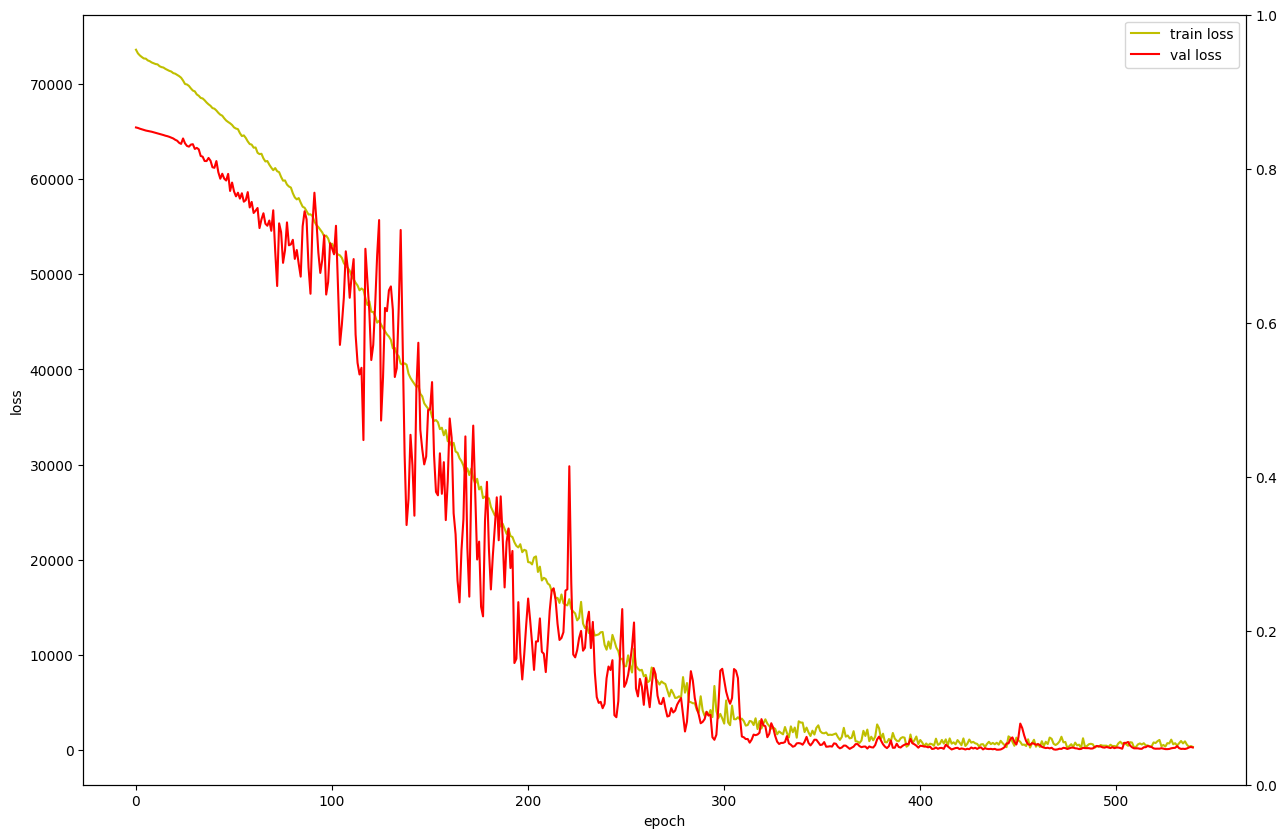

In [25]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.legend()
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

plt.show()

## 결정 계수(r2_score)
생성한 모델이 얼마나 데이터를 잘 설명하는가?

In [26]:
# X 입력 -> 모델을 거쳐서 -> y 출력
y_train_predict = model.predict(X_train)

4/4 [==============================] - 1s 6ms/step


In [27]:
print(r2_score(y_train, y_train_predict))

0.9653633504444783


In [28]:
# mean_squared_error: 잔차의 제곱의 평균 = 잔차가 큰 데이터를 더 큰 패널티를 주는 것

# √mean_squared_error: 루트를 씌워주는 이유는 제곱을 지워주기 위해서
print(math.sqrt(mean_squared_error(y_train, y_train_predict)))  # sqrt: 루트

17.46791241526939


In [29]:
y_test_predict = model.predict(X_test)

2/2 [==============================] - 0s 7ms/step


In [30]:
print(r2_score(y_test, y_test_predict))

0.9706117524444532


In [31]:
# √mean_squared_error
print(math.sqrt(mean_squared_error(y_test, y_test_predict)))

16.604609673041992


## 예측

In [32]:
# 2023년 1월의 종가 데이터
test_list = [390.58, 395.52, 396.96, 398.50, 397.77, 391.49, 388.64, 395.88, 400.63, 400.20, 400.35, 404.75, 405.68, 400.59, 406.48]

In [33]:
# 딥러닝 모델에 넣기 위해 리스트를 넘파이 배열로 변환
test_array = np.array(test_list)

In [34]:
# 2023년 2월 1일의 종가 예측
print(model.predict(test_array.reshape(1, test_array.shape[0], 1)))

1/1 [==============================] - 1s 633ms/step
[[433.2061]]


실제값: 410.80

## 실제값과 예측값 시각화

In [35]:
# X1: 원본의 X 데이터가 들어가 있음
# LSTM에 들어갈 수 있도록 reshape하기
visual_predict = model.predict(X1.reshape(143, 15, 1))

5/5 [==============================] - 0s 6ms/step


In [37]:
# df_month: 예측할 데이터 프레임 = 매 월의 1일 데이터만 들어가 있음
df_date = df_month[['Date']].reset_index(drop = True)  # reset_index(drop = True): 순서 맞추기 위해 한거야 신경 쓰지마

In [38]:
# y_list: df_month를 리스트로 바꾼 것
visual_t = pd.DataFrame(y_list).reset_index(drop = True)

In [39]:
# concat: 두 개의 데이터 프레임 합치기 / axis = 1: 축 지정해서 Close-Date 형태로 만들어진다.
visual_t = pd.concat([visual_t, df_date], axis = 1)
visual_t.rename({0 : 'Close'}, axis = 'columns', inplace = True)  # inplace = True: 원본까지 바꾸기
visual_t
# 사실 df_y = visual_t 같은 것이당

,Close,Date
0,130.740005,2011-02-01
1,130.929993,2011-03-01
2,133.149994,2011-04-01
3,136.220001,2011-05-02
4,131.869995,2011-06-01
...,...,...
138,410.769989,2022-08-01
139,396.420013,2022-09-01
140,366.609985,2022-10-03
141,384.519989,2022-11-01


In [40]:
# visual_predict(원래 X값을 학습된 모델에 넣은 것)를 DataFrame으로 만들기
visual_y = pd.DataFrame(visual_predict).reset_index(drop = True)

In [41]:
visual_y = pd.concat([visual_y, df_date], axis = 1)
visual_y.rename({0 : 'Close'}, axis = 'columns', inplace = True)
visual_y

,Close,Date
0,137.132492,2011-02-01
1,143.435165,2011-03-01
2,141.282806,2011-04-01
3,146.757431,2011-05-02
4,145.404602,2011-06-01
...,...,...
138,433.086060,2022-08-01
139,431.271820,2022-09-01
140,388.809418,2022-10-03
141,407.310028,2022-11-01


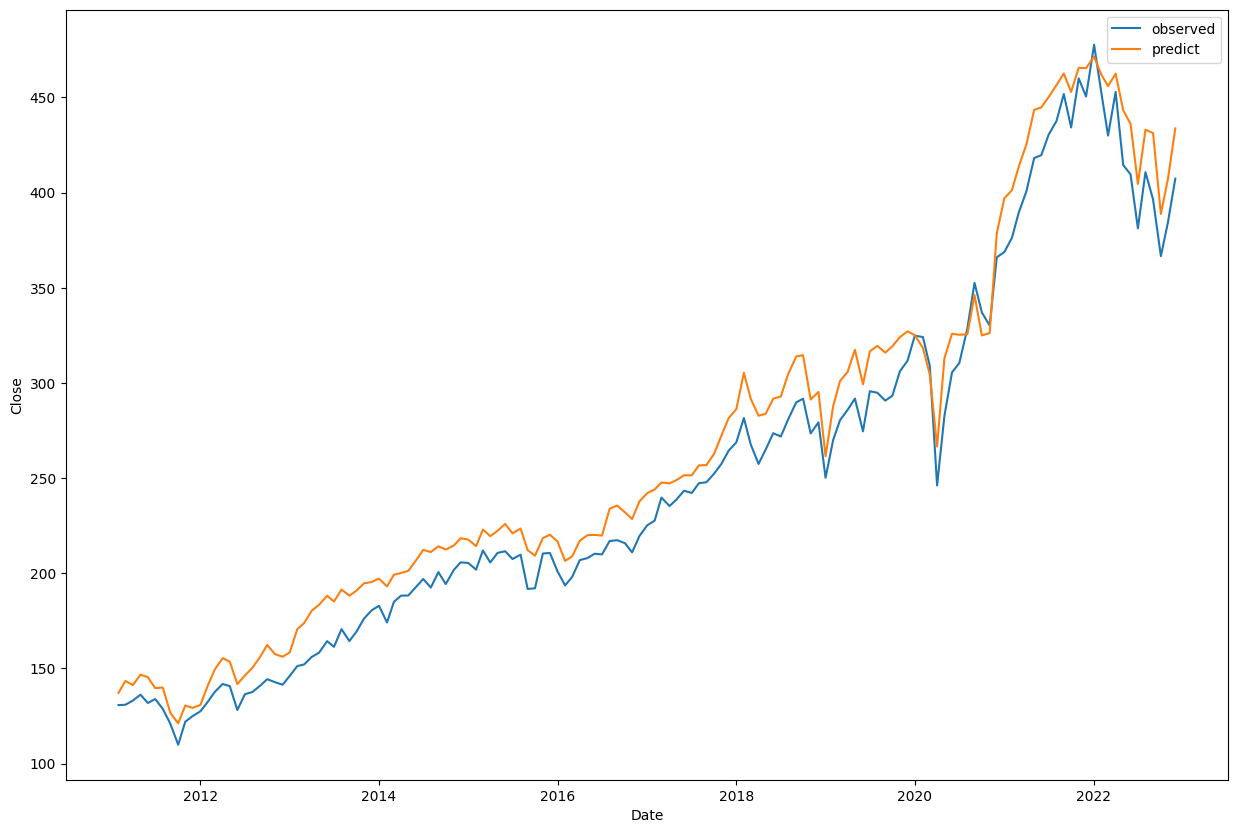

In [42]:
sns.lineplot(visual_t, x = 'Date', y = 'Close', label='observed')
sns.lineplot(visual_y, x = 'Date', y = 'Close', label='predict')
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()

# 분기별 예측

In [46]:
df1 = df.set_index('Date')  # Date를 인덱스로 지정
df_quarter = pd.DataFrame(df1['Close'].resample('3BMS').first())  # y: 분기의 첫날(BMS)의 종가로 지정
df1 = df1.reset_index()  # 다시 컬럼으로 변환
df_quarter = df_quarter.reset_index()
df_quarter = df_quarter.iloc[1:, :]  # 11년 1월을 예측할 데이터가 존재하지 않기 때문에 제외

In [47]:
df1 = df1.reset_index()

In [48]:
x_list = []

In [49]:
for i in range(2011, 2023):
    for j in range(1, 13):
        if j < 9:
            cond = (df1['Date'] >= (str(i) + '-' + str(0) + str(j))) & (
                        df1['Date'] < (str(i) + '-' + str(0) + str(j + 1)))
            x_list.append(df1.loc[cond]['Close'].values)
        elif j == 9:
            cond = (df1['Date'] >= (str(i) + '-' + str(0) + str(j))) & (df1['Date'] < (str(i) + '-' + str(j + 1)))
            x_list.append(df1.loc[cond]['Close'].values)
        elif j == 12:
            cond = (df1['Date'] >= (str(i) + '-' + str(j))) & (df1['Date'] < (str(i + 1) + '-' + str(0) + str(1)))
            x_list.append(df1.loc[cond]['Close'].values)
        else:
            cond = (df1['Date'] >= (str(i) + '-' + str(j))) & (df1['Date'] < (str(i) + '-' + str(j + 1)))
            x_list.append(df1.loc[cond]['Close'].values)

In [50]:
x_list

[array([127.0500031, 126.9800034, 127.6399994, 127.3899994, 127.1399994,
        126.9800034, 127.4300003, 128.5800018, 128.3699951, 129.3000031,
        129.5200043, 128.25     , 128.0800018, 128.3699951, 129.1000061,
        129.1699982, 129.6699982, 129.9900055, 127.7200012, 128.6799927]),
 array([130.7400055, 130.4900055, 130.7799988, 131.1499939, 131.9700012,
        132.5700073, 132.2700043, 132.3200073, 133.1100006, 133.4299927,
        133.0099945, 133.8500061, 134.25     , 134.5299988, 131.8300018,
        131.0200043, 130.9299927, 132.3300018, 133.1499939]),
 array([130.9299927, 131.2100067, 133.4700012, 132.4700012, 131.4299927,
        132.5800018, 132.3899994, 129.9400024, 130.8399963, 130.0500031,
        128.5599976, 126.1800003, 127.8499985, 127.7600021, 129.7400055,
        129.2899933, 129.6600037, 130.8999939, 131.3000031, 130.9799957,
        131.8600006, 132.7700043, 132.5899963]),
 array([133.1499939, 133.2599945, 133.2400055, 133.6600037, 133.3200073,
        132

In [51]:
len(x_list)

144

In [52]:
x_list_fin = []

In [53]:
# 3개월씩 묶어주기
for i in range(len(x_list)):
    if i % 3 == 0:
        x_list_fin.append(np.concatenate((x_list[i], x_list[i+1], x_list[i+2])))
    else :
        continue

In [58]:
# 각 분기별 가장 적은 분기 영업일수 찾기
min = 100  # 임의의 큰 수 설정

for i in range(len(x_list_fin)):
    if len(x_list_fin[i]) < min:
        min = len(x_list_fin[i])

print(min)

60


In [54]:
x_list_fin_fin = []

In [59]:
# 각 분기별 가장 적은 영업일수가 60일이니까 모든 분기별 데이터를 60일로 맞춰주기
for i in range(len(x_list_fin)):
    x_list_fin_fin.append(x_list_fin[i][-60:])

In [60]:
x_list_fin_fin

[array([127.6399994, 127.3899994, 127.1399994, 126.9800034, 127.4300003,
        128.5800018, 128.3699951, 129.3000031, 129.5200043, 128.25     ,
        128.0800018, 128.3699951, 129.1000061, 129.1699982, 129.6699982,
        129.9900055, 127.7200012, 128.6799927, 130.7400055, 130.4900055,
        130.7799988, 131.1499939, 131.9700012, 132.5700073, 132.2700043,
        132.3200073, 133.1100006, 133.4299927, 133.0099945, 133.8500061,
        134.25     , 134.5299988, 131.8300018, 131.0200043, 130.9299927,
        132.3300018, 133.1499939, 130.9299927, 131.2100067, 133.4700012,
        132.4700012, 131.4299927, 132.5800018, 132.3899994, 129.9400024,
        130.8399963, 130.0500031, 128.5599976, 126.1800003, 127.8499985,
        127.7600021, 129.7400055, 129.2899933, 129.6600037, 130.8999939,
        131.3000031, 130.9799957, 131.8600006, 132.7700043, 132.5899963]),
 array([133.6600037, 133.3200073, 132.8600006, 132.4600067, 131.4700012,
        131.4600067, 131.5599976, 132.0399933, 13

In [61]:
X = np.array(x_list_fin_fin)

In [62]:
y_list = []

In [64]:
for i in range(len(df_quarter['Close'].tolist())):
    y_list.append(np.array([df_quarter['Close'].tolist()[i]]))

In [65]:
y = np.array(y_list)

## 분기별 LSTM

In [67]:
X1 = X[:-1]

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, random_state = 42)

In [71]:
x = layers.Input(shape=(X_train.shape[1], 1))
lstm = layers.LSTM(32, return_sequences = False)(x)
#Dropout = layers.Dropout(0.3)(lstm)
dense = layers.Dense(16)(lstm)
norm = layers.BatchNormalization()(dense)
relu = layers.ReLU()(norm)
#dense = layers.Dense(8)(relu)
#norm = layers.BatchNormalization()(dense)
#relu = layers.ReLU()(norm)
y = layers.Dense(1)(relu)
model = models.Model(x, y)
optimizer = optimizers.Adam(learning_rate=1e-3)

model.compile(optimizer, 'mean_squared_error')  # loss function: mean_squared_error 사용

In [72]:
# EarlyStopping: val_loss가 제일 낮아도 Epoch 100번은 더 해봐라
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=150)

In [73]:
# 모델 학습
history = model.fit(X_train, y_train, epochs = 2000, validation_data = [X_test, y_test], 
                    batch_size = 16, verbose = 1)

Epoch 1/2000
3/3 [==============================] - 5s 553ms/step - loss: 71646.4141 - val_loss: 67901.5156
Epoch 2/2000
3/3 [==============================] - 0s 100ms/step - loss: 71597.7109 - val_loss: 67891.1719
Epoch 3/2000
3/3 [==============================] - 0s 65ms/step - loss: 71553.8984 - val_loss: 67881.4609
Epoch 4/2000
3/3 [==============================] - 0s 67ms/step - loss: 71460.0078 - val_loss: 67870.3203
Epoch 5/2000
3/3 [==============================] - 0s 72ms/step - loss: 71417.2500 - val_loss: 67852.9375
Epoch 6/2000
3/3 [==============================] - 0s 67ms/step - loss: 71417.4062 - val_loss: 67836.8438
Epoch 7/2000
3/3 [==============================] - 0s 74ms/step - loss: 71383.4219 - val_loss: 67814.7656
Epoch 8/2000
3/3 [==============================] - 0s 70ms/step - loss: 71353.2188 - val_loss: 67793.1016
Epoch 9/2000
3/3 [==============================] - 0s 67ms/step - loss: 71342.6484 - val_loss: 67780.8438
Epoch 10/2000
3/3 [================

Epoch 77/2000
3/3 [==============================] - 0s 39ms/step - loss: 70153.5938 - val_loss: 66478.1016
Epoch 78/2000
3/3 [==============================] - 0s 40ms/step - loss: 70094.4844 - val_loss: 66489.7266
Epoch 79/2000
3/3 [==============================] - 0s 44ms/step - loss: 70099.1562 - val_loss: 66554.3828
Epoch 80/2000
3/3 [==============================] - 0s 41ms/step - loss: 70060.8594 - val_loss: 66578.3438
Epoch 81/2000
3/3 [==============================] - 0s 52ms/step - loss: 70024.2344 - val_loss: 66589.5000
Epoch 82/2000
3/3 [==============================] - 0s 51ms/step - loss: 70016.7031 - val_loss: 66569.8047
Epoch 83/2000
3/3 [==============================] - 0s 50ms/step - loss: 70012.3203 - val_loss: 66532.7734
Epoch 84/2000
3/3 [==============================] - 0s 45ms/step - loss: 69981.1406 - val_loss: 66474.5781
Epoch 85/2000
3/3 [==============================] - 0s 45ms/step - loss: 69967.9219 - val_loss: 66397.7734
Epoch 86/2000
3/3 [=========

3/3 [==============================] - 0s 64ms/step - loss: 63474.2422 - val_loss: 61903.9023
Epoch 228/2000
3/3 [==============================] - 0s 64ms/step - loss: 63271.0430 - val_loss: 61431.9805
Epoch 229/2000
3/3 [==============================] - 0s 54ms/step - loss: 63201.5156 - val_loss: 61000.8086
Epoch 230/2000
3/3 [==============================] - 0s 45ms/step - loss: 63262.6367 - val_loss: 60904.0508
Epoch 231/2000
3/3 [==============================] - 0s 41ms/step - loss: 63421.5938 - val_loss: 60915.8164
Epoch 232/2000
3/3 [==============================] - 0s 99ms/step - loss: 63156.0078 - val_loss: 61776.9570
Epoch 233/2000
3/3 [==============================] - 0s 80ms/step - loss: 63027.9062 - val_loss: 61772.1133
Epoch 234/2000
3/3 [==============================] - 0s 65ms/step - loss: 62984.2578 - val_loss: 60841.3008
Epoch 235/2000
3/3 [==============================] - 0s 41ms/step - loss: 62911.8555 - val_loss: 60119.8398
Epoch 236/2000
3/3 [==============

3/3 [==============================] - 0s 44ms/step - loss: 51631.1914 - val_loss: 51397.1406
Epoch 378/2000
3/3 [==============================] - 0s 44ms/step - loss: 52141.2148 - val_loss: 53583.5742
Epoch 379/2000
3/3 [==============================] - 0s 41ms/step - loss: 52068.3711 - val_loss: 57285.2305
Epoch 380/2000
3/3 [==============================] - 0s 45ms/step - loss: 51878.0664 - val_loss: 60206.3555
Epoch 381/2000
3/3 [==============================] - 0s 39ms/step - loss: 51944.4492 - val_loss: 61279.9688
Epoch 382/2000
3/3 [==============================] - 0s 46ms/step - loss: 51666.4453 - val_loss: 61295.3281
Epoch 383/2000
3/3 [==============================] - 0s 42ms/step - loss: 51758.2969 - val_loss: 58645.3906
Epoch 384/2000
3/3 [==============================] - 0s 41ms/step - loss: 51299.1484 - val_loss: 55418.6875
Epoch 385/2000
3/3 [==============================] - 0s 41ms/step - loss: 51234.6094 - val_loss: 52256.3711
Epoch 386/2000
3/3 [==============

3/3 [==============================] - 0s 37ms/step - loss: 37479.6445 - val_loss: 32256.5176
Epoch 528/2000
3/3 [==============================] - 0s 38ms/step - loss: 37226.8516 - val_loss: 33817.1211
Epoch 529/2000
3/3 [==============================] - 0s 42ms/step - loss: 36824.8047 - val_loss: 34480.5312
Epoch 530/2000
3/3 [==============================] - 0s 40ms/step - loss: 37642.3008 - val_loss: 34694.4375
Epoch 531/2000
3/3 [==============================] - 0s 39ms/step - loss: 36261.4102 - val_loss: 35541.9375
Epoch 532/2000
3/3 [==============================] - 0s 62ms/step - loss: 36733.6758 - val_loss: 36706.6055
Epoch 533/2000
3/3 [==============================] - 0s 58ms/step - loss: 36352.1758 - val_loss: 36381.9062
Epoch 534/2000
3/3 [==============================] - 0s 56ms/step - loss: 36386.6953 - val_loss: 34169.9883
Epoch 535/2000
3/3 [==============================] - 0s 69ms/step - loss: 35858.3594 - val_loss: 32871.9805
Epoch 536/2000
3/3 [==============

3/3 [==============================] - 0s 41ms/step - loss: 23372.2480 - val_loss: 15698.4404
Epoch 678/2000
3/3 [==============================] - 0s 42ms/step - loss: 22339.1641 - val_loss: 17029.2715
Epoch 679/2000
3/3 [==============================] - 0s 43ms/step - loss: 22299.7852 - val_loss: 19615.6699
Epoch 680/2000
3/3 [==============================] - 0s 46ms/step - loss: 22697.5527 - val_loss: 20370.3594
Epoch 681/2000
3/3 [==============================] - 0s 47ms/step - loss: 22311.6777 - val_loss: 20673.3555
Epoch 682/2000
3/3 [==============================] - 0s 50ms/step - loss: 23255.8164 - val_loss: 20340.8672
Epoch 683/2000
3/3 [==============================] - 0s 39ms/step - loss: 21682.5664 - val_loss: 18949.2480
Epoch 684/2000
3/3 [==============================] - 0s 40ms/step - loss: 21602.3574 - val_loss: 16960.8887
Epoch 685/2000
3/3 [==============================] - 0s 42ms/step - loss: 22437.4316 - val_loss: 16385.2832
Epoch 686/2000
3/3 [==============

3/3 [==============================] - 0s 45ms/step - loss: 14400.9053 - val_loss: 7172.4648
Epoch 828/2000
3/3 [==============================] - 0s 42ms/step - loss: 12451.8906 - val_loss: 6777.6509
Epoch 829/2000
3/3 [==============================] - 0s 41ms/step - loss: 12925.9141 - val_loss: 6436.5386
Epoch 830/2000
3/3 [==============================] - 0s 40ms/step - loss: 12352.9912 - val_loss: 5981.7554
Epoch 831/2000
3/3 [==============================] - 0s 39ms/step - loss: 11703.0361 - val_loss: 5886.3345
Epoch 832/2000
3/3 [==============================] - 0s 45ms/step - loss: 12032.7803 - val_loss: 6363.4038
Epoch 833/2000
3/3 [==============================] - 0s 49ms/step - loss: 11661.0361 - val_loss: 7477.0991
Epoch 834/2000
3/3 [==============================] - 0s 45ms/step - loss: 13156.2773 - val_loss: 9180.7949
Epoch 835/2000
3/3 [==============================] - 0s 47ms/step - loss: 11674.0576 - val_loss: 10800.8252
Epoch 836/2000
3/3 [======================

3/3 [==============================] - 0s 79ms/step - loss: 9338.0986 - val_loss: 20676.1348
Epoch 979/2000
3/3 [==============================] - 0s 66ms/step - loss: 7555.4399 - val_loss: 20178.3965
Epoch 980/2000
3/3 [==============================] - 0s 78ms/step - loss: 6586.6572 - val_loss: 18843.9160
Epoch 981/2000
3/3 [==============================] - 0s 78ms/step - loss: 6229.2646 - val_loss: 16881.8027
Epoch 982/2000
3/3 [==============================] - 0s 92ms/step - loss: 6026.8086 - val_loss: 15012.5166
Epoch 983/2000
3/3 [==============================] - 0s 66ms/step - loss: 6721.3037 - val_loss: 13090.5039
Epoch 984/2000
3/3 [==============================] - 0s 60ms/step - loss: 6114.6592 - val_loss: 11095.1357
Epoch 985/2000
3/3 [==============================] - 0s 75ms/step - loss: 6337.0439 - val_loss: 10246.3633
Epoch 986/2000
3/3 [==============================] - 0s 131ms/step - loss: 8698.6309 - val_loss: 9232.7393
Epoch 987/2000
3/3 [=======================

Epoch 1054/2000
3/3 [==============================] - 0s 73ms/step - loss: 5548.0000 - val_loss: 5482.4355
Epoch 1055/2000
3/3 [==============================] - 0s 51ms/step - loss: 4605.5171 - val_loss: 4890.7188
Epoch 1056/2000
3/3 [==============================] - 0s 56ms/step - loss: 4579.9590 - val_loss: 3949.2458
Epoch 1057/2000
3/3 [==============================] - 0s 58ms/step - loss: 4912.9541 - val_loss: 3521.9277
Epoch 1058/2000
3/3 [==============================] - 0s 52ms/step - loss: 5324.5859 - val_loss: 3542.4470
Epoch 1059/2000
3/3 [==============================] - 0s 56ms/step - loss: 3893.2825 - val_loss: 3852.0361
Epoch 1060/2000
3/3 [==============================] - 0s 54ms/step - loss: 6564.4233 - val_loss: 4250.9717
Epoch 1061/2000
3/3 [==============================] - 0s 56ms/step - loss: 4016.6509 - val_loss: 4554.1704
Epoch 1062/2000
3/3 [==============================] - 0s 56ms/step - loss: 4945.8989 - val_loss: 4795.8813
Epoch 1063/2000
3/3 [=======

Epoch 1130/2000
3/3 [==============================] - 0s 62ms/step - loss: 2931.2588 - val_loss: 1693.3942
Epoch 1131/2000
3/3 [==============================] - 0s 64ms/step - loss: 3022.0198 - val_loss: 1559.5597
Epoch 1132/2000
3/3 [==============================] - 0s 63ms/step - loss: 3064.2605 - val_loss: 1772.4668
Epoch 1133/2000
3/3 [==============================] - 0s 64ms/step - loss: 3391.7874 - val_loss: 1928.3712
Epoch 1134/2000
3/3 [==============================] - 0s 66ms/step - loss: 3407.9072 - val_loss: 1828.6901
Epoch 1135/2000
3/3 [==============================] - 0s 61ms/step - loss: 3028.1692 - val_loss: 1967.1652
Epoch 1136/2000
3/3 [==============================] - 0s 56ms/step - loss: 3316.6055 - val_loss: 1889.4205
Epoch 1137/2000
3/3 [==============================] - 0s 56ms/step - loss: 4252.0410 - val_loss: 1434.4801
Epoch 1138/2000
3/3 [==============================] - 0s 57ms/step - loss: 3644.0266 - val_loss: 1045.3575
Epoch 1139/2000
3/3 [=======

3/3 [==============================] - 0s 74ms/step - loss: 2606.9902 - val_loss: 2461.5049
Epoch 1207/2000
3/3 [==============================] - 0s 59ms/step - loss: 3334.5715 - val_loss: 1503.1904
Epoch 1208/2000
3/3 [==============================] - 0s 79ms/step - loss: 2292.4954 - val_loss: 522.8160
Epoch 1209/2000
3/3 [==============================] - 0s 62ms/step - loss: 2741.6829 - val_loss: 251.7913
Epoch 1210/2000
3/3 [==============================] - 0s 58ms/step - loss: 3000.3064 - val_loss: 218.9684
Epoch 1211/2000
3/3 [==============================] - 0s 62ms/step - loss: 2300.3716 - val_loss: 151.5875
Epoch 1212/2000
3/3 [==============================] - 0s 82ms/step - loss: 2762.2070 - val_loss: 168.3360
Epoch 1213/2000
3/3 [==============================] - 0s 73ms/step - loss: 1760.9434 - val_loss: 148.5756
Epoch 1214/2000
3/3 [==============================] - 0s 65ms/step - loss: 2298.7695 - val_loss: 267.2595
Epoch 1215/2000
3/3 [==============================

3/3 [==============================] - 0s 87ms/step - loss: 1188.1433 - val_loss: 5826.5942
Epoch 1359/2000
3/3 [==============================] - 0s 49ms/step - loss: 691.1565 - val_loss: 4867.1440
Epoch 1360/2000
3/3 [==============================] - 0s 45ms/step - loss: 820.5549 - val_loss: 4462.8999
Epoch 1361/2000
3/3 [==============================] - 0s 73ms/step - loss: 809.5364 - val_loss: 4929.0688
Epoch 1362/2000
3/3 [==============================] - 0s 72ms/step - loss: 3934.2849 - val_loss: 3663.6699
Epoch 1363/2000
3/3 [==============================] - 0s 76ms/step - loss: 1572.9772 - val_loss: 1364.7489
Epoch 1364/2000
3/3 [==============================] - 0s 62ms/step - loss: 802.0219 - val_loss: 703.2661
Epoch 1365/2000
3/3 [==============================] - 0s 54ms/step - loss: 1621.4375 - val_loss: 671.3017
Epoch 1366/2000
3/3 [==============================] - 0s 46ms/step - loss: 1346.9039 - val_loss: 953.3091
Epoch 1367/2000
3/3 [==============================

Epoch 1511/2000
3/3 [==============================] - 0s 81ms/step - loss: 1087.0769 - val_loss: 223.3115
Epoch 1512/2000
3/3 [==============================] - 0s 179ms/step - loss: 662.7562 - val_loss: 460.6688
Epoch 1513/2000
3/3 [==============================] - 0s 110ms/step - loss: 487.2730 - val_loss: 590.5659
Epoch 1514/2000
3/3 [==============================] - 0s 81ms/step - loss: 970.5989 - val_loss: 258.9814
Epoch 1515/2000
3/3 [==============================] - 0s 67ms/step - loss: 1052.2025 - val_loss: 326.5264
Epoch 1516/2000
3/3 [==============================] - 0s 73ms/step - loss: 1220.1779 - val_loss: 772.9946
Epoch 1517/2000
3/3 [==============================] - 0s 67ms/step - loss: 1405.2720 - val_loss: 1451.7518
Epoch 1518/2000
3/3 [==============================] - 0s 76ms/step - loss: 752.9404 - val_loss: 1631.8070
Epoch 1519/2000
3/3 [==============================] - 0s 71ms/step - loss: 1025.7965 - val_loss: 752.5336
Epoch 1520/2000
3/3 [================

Epoch 1588/2000
3/3 [==============================] - 0s 68ms/step - loss: 1311.8683 - val_loss: 257.0871
Epoch 1589/2000
3/3 [==============================] - 1s 263ms/step - loss: 296.9380 - val_loss: 264.0277
Epoch 1590/2000
3/3 [==============================] - 0s 203ms/step - loss: 1240.8219 - val_loss: 282.1732
Epoch 1591/2000
3/3 [==============================] - 0s 145ms/step - loss: 909.1823 - val_loss: 308.3317
Epoch 1592/2000
3/3 [==============================] - 0s 76ms/step - loss: 585.4825 - val_loss: 401.7284
Epoch 1593/2000
3/3 [==============================] - 0s 71ms/step - loss: 1441.7683 - val_loss: 442.7258
Epoch 1594/2000
3/3 [==============================] - 0s 76ms/step - loss: 1067.8792 - val_loss: 437.3544
Epoch 1595/2000
3/3 [==============================] - 0s 74ms/step - loss: 481.3402 - val_loss: 549.2629
Epoch 1596/2000
3/3 [==============================] - 0s 74ms/step - loss: 588.0071 - val_loss: 649.2936
Epoch 1597/2000
3/3 [==================

Epoch 1741/2000
3/3 [==============================] - 0s 42ms/step - loss: 1024.2000 - val_loss: 388.5895
Epoch 1742/2000
3/3 [==============================] - 0s 38ms/step - loss: 872.7193 - val_loss: 395.2611
Epoch 1743/2000
3/3 [==============================] - 0s 43ms/step - loss: 664.8799 - val_loss: 494.1486
Epoch 1744/2000
3/3 [==============================] - 0s 40ms/step - loss: 1563.5703 - val_loss: 726.9514
Epoch 1745/2000
3/3 [==============================] - 0s 43ms/step - loss: 729.2376 - val_loss: 741.2236
Epoch 1746/2000
3/3 [==============================] - 0s 81ms/step - loss: 801.6082 - val_loss: 804.6115
Epoch 1747/2000
3/3 [==============================] - 0s 79ms/step - loss: 439.6545 - val_loss: 858.6398
Epoch 1748/2000
3/3 [==============================] - 0s 99ms/step - loss: 1521.9047 - val_loss: 1004.0283
Epoch 1749/2000
3/3 [==============================] - 0s 55ms/step - loss: 288.7342 - val_loss: 1435.2476
Epoch 1750/2000
3/3 [====================

Epoch 1818/2000
3/3 [==============================] - 0s 51ms/step - loss: 173.3791 - val_loss: 402.6944
Epoch 1819/2000
3/3 [==============================] - 0s 50ms/step - loss: 335.3382 - val_loss: 439.8581
Epoch 1820/2000
3/3 [==============================] - 0s 62ms/step - loss: 981.7911 - val_loss: 408.2577
Epoch 1821/2000
3/3 [==============================] - 0s 46ms/step - loss: 344.4612 - val_loss: 407.3657
Epoch 1822/2000
3/3 [==============================] - 0s 42ms/step - loss: 984.6588 - val_loss: 399.5174
Epoch 1823/2000
3/3 [==============================] - 0s 53ms/step - loss: 487.5522 - val_loss: 386.6303
Epoch 1824/2000
3/3 [==============================] - 0s 47ms/step - loss: 186.0475 - val_loss: 349.8742
Epoch 1825/2000
3/3 [==============================] - 0s 41ms/step - loss: 902.8744 - val_loss: 259.5199
Epoch 1826/2000
3/3 [==============================] - 0s 41ms/step - loss: 127.3216 - val_loss: 489.6266
Epoch 1827/2000
3/3 [=========================

Epoch 1895/2000
3/3 [==============================] - 0s 61ms/step - loss: 688.4258 - val_loss: 500.2292
Epoch 1896/2000
3/3 [==============================] - 0s 64ms/step - loss: 512.8801 - val_loss: 436.5647
Epoch 1897/2000
3/3 [==============================] - 0s 51ms/step - loss: 842.1295 - val_loss: 539.9485
Epoch 1898/2000
3/3 [==============================] - 0s 56ms/step - loss: 325.4319 - val_loss: 560.2504
Epoch 1899/2000
3/3 [==============================] - 0s 49ms/step - loss: 133.9964 - val_loss: 483.5079
Epoch 1900/2000
3/3 [==============================] - 0s 44ms/step - loss: 1152.1918 - val_loss: 451.5409
Epoch 1901/2000
3/3 [==============================] - 0s 44ms/step - loss: 406.2610 - val_loss: 414.0381
Epoch 1902/2000
3/3 [==============================] - 0s 57ms/step - loss: 217.0453 - val_loss: 312.4818
Epoch 1903/2000
3/3 [==============================] - 0s 54ms/step - loss: 953.2768 - val_loss: 309.1191
Epoch 1904/2000
3/3 [========================

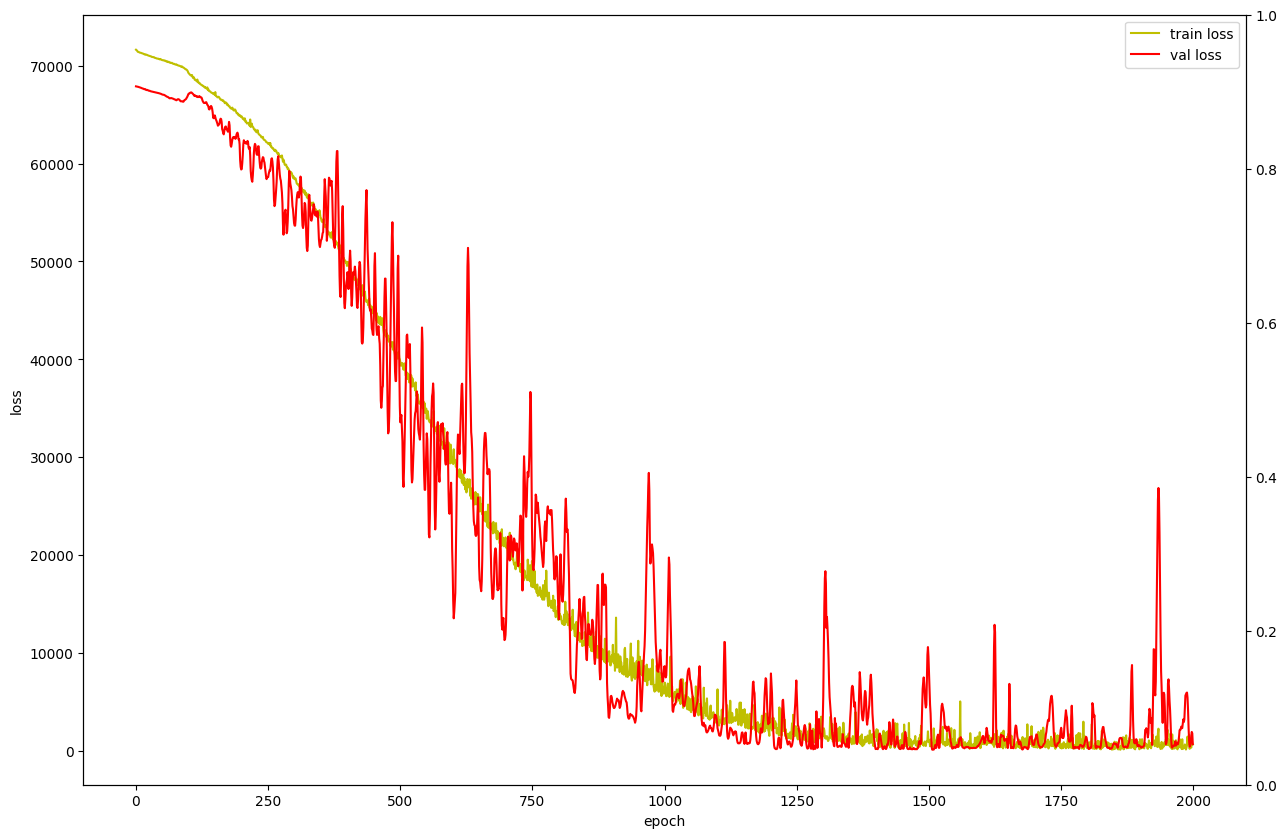

In [74]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.legend()
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

plt.show()

## 결정 계수

In [75]:
# X 입력 -> 모델을 거쳐서 -> y 출력
y_train_predict = model.predict(X_train)

2/2 [==============================] - 1s 8ms/step


In [76]:
print(r2_score(y_train, y_train_predict))

0.935883675498346


In [77]:
# mean_squared_error: 잔차의 제곱의 평균 = 잔차가 큰 데이터를 더 큰 패널티를 주는 것

# √mean_squared_error: 루트를 씌워주는 이유는 제곱을 지워주기 위해서
print(math.sqrt(mean_squared_error(y_train, y_train_predict)))  # sqrt: 루트

23.685587985253402


In [78]:
y_test_predict = model.predict(X_test)

1/1 [==============================] - 0s 32ms/step


In [79]:
print(r2_score(y_test, y_test_predict))

0.9269867180223401


In [80]:
# √mean_squared_error
print(math.sqrt(mean_squared_error(y_test, y_test_predict)))

25.588918493699218


## 예측

In [81]:
# 2022년 11월~ 2023년 1월 종가 데이터
test_list = pd.read_csv('./SPY_quarter.csv')  # test_list: 데이터프레임 형태

In [82]:
# 데이터 프레임 형태에서 시리즈를 뽑아서 넘파이 배열로 변환
test_array = np.array(test_list['Close'])

In [83]:
# 2023년 2월 1일의 종가 예측
print(model.predict(test_array.reshape(1, test_array.shape[0], 1)))

1/1 [==============================] - 1s 618ms/step
[[416.5431]]


실제값: 410.80

## 실제값과 예측값 시각화

In [85]:
# X1: 원본의 X 데이터가 들어가 있음
# LSTM에 들어갈 수 있도록 reshape하기
visual_predict = model.predict(X1.reshape(47, 60, 1))

2/2 [==============================] - 0s 9ms/step


In [87]:
# df_y: 예측할 데이터 프레임 = 매 월의 1일 데이터만 들어가 있음
df_date = df_quarter[['Date']].reset_index(drop = True)  # reset_index(drop = True): 순서 맞추기 위해 한거야 신경 쓰지마

In [88]:
# y_list: df_y를 리스트로 바꾼 것
visual_t = pd.DataFrame(y_list).reset_index(drop = True)

In [89]:
# concat: 두 개의 데이터 프레임 합치기 / axis = 1: 축 지정해서 Close-Date 형태로 만들어진다.
visual_t = pd.concat([visual_t, df_date], axis = 1)
visual_t.rename({0 : 'Close'}, axis = 'columns', inplace = True)  # inplace = True: 원본까지 바꾸기
visual_t
# 사실 df_y = visual_t 같은 것이당

,Close,Date
0,133.149994,2011-04-01
1,133.919998,2011-07-01
2,109.930000,2011-10-03
3,127.500000,2012-01-02
4,141.839996,2012-04-02
5,136.509995,2012-07-02
6,144.350006,2012-10-01
7,146.059998,2013-01-01
8,156.050003,2013-04-01
9,161.360001,2013-07-01


In [90]:
# visual_predict(원래 X값을 학습된 모델에 넣은 것)를 DataFrame으로 만들기
visual_y = pd.DataFrame(visual_predict).reset_index(drop = True)

In [91]:
visual_y = pd.concat([visual_y, df_date], axis = 1)
visual_y.rename({0 : 'Close'}, axis = 'columns', inplace = True)
visual_y

,Close,Date
0,151.578217,2011-04-01
1,152.878586,2011-07-01
2,131.875885,2011-10-03
3,137.906784,2012-01-02
4,159.209106,2012-04-02
5,157.145248,2012-07-02
6,164.533112,2012-10-01
7,164.994980,2013-01-01
8,176.547440,2013-04-01
9,182.300613,2013-07-01


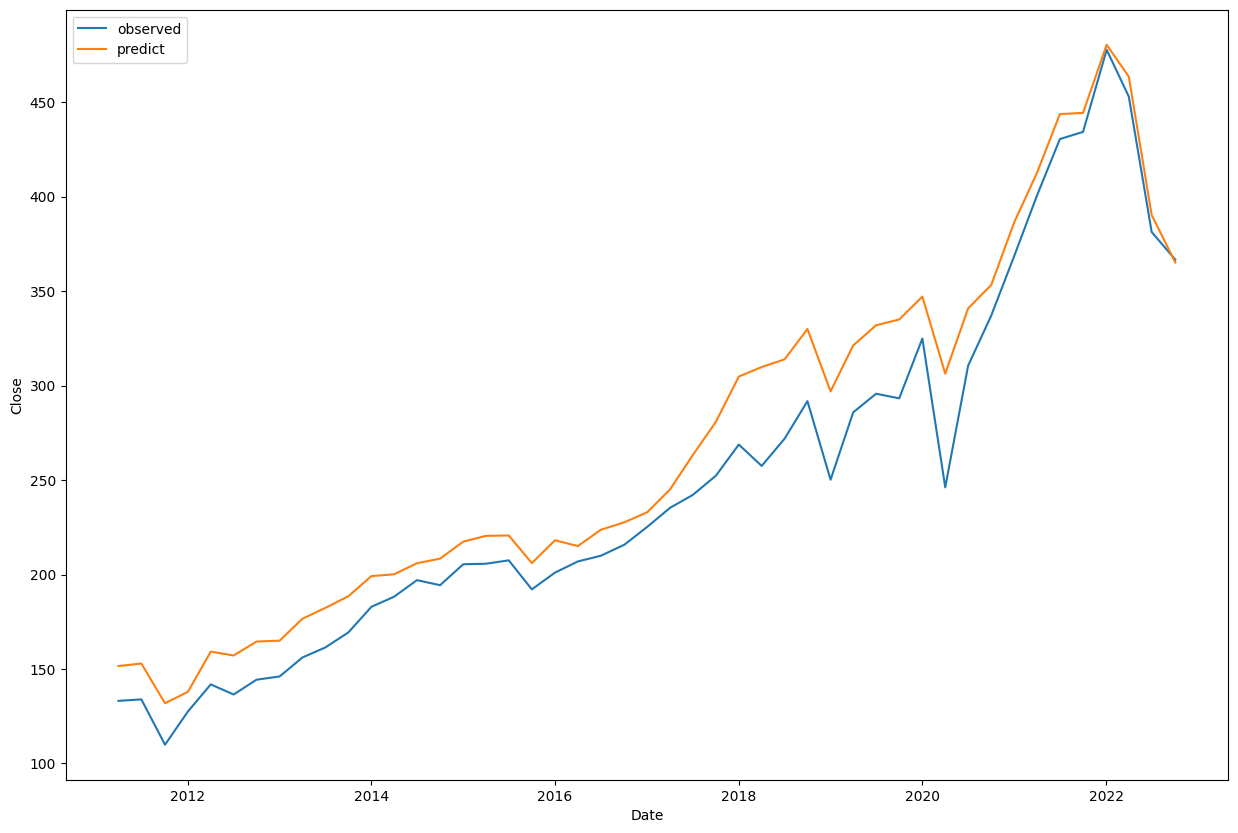

In [92]:
sns.lineplot(visual_t, x = 'Date', y = 'Close', label='observed')
sns.lineplot(visual_y, x = 'Date', y = 'Close', label='predict')
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()

# 일별 예측

In [94]:
df1 = df.set_index('Date').iloc[:-1,:]  # 마지막 Date 제거 (왜냐? 23년 1월 1일 데이터가 없어서 X값의 마지막 Date가 필요 없어)
df_day = df.iloc[1:, :]  # 데이터의 첫 날을 예측할 데이터가 존재하지 않기 때문에 제외
df_day = df_day.set_index('Date')

In [95]:
df1 = df1.reset_index()

In [96]:
x_list = []

In [97]:
# 모델을 만드는 목적: 전 날의 Close로 다음 날의 Close를 예측한다.

# 모델 학습에 필요한 데이터 정제
# 하루(1일)의 데이터를 묶어준다. -> 묶어준 데이터들을 x_list에 넣어준다.
for i in range(len(df1)):
    x_list.append([df1['Close'].values[i]])

In [98]:
x_list

[[127.0500031],
 [126.9800034],
 [127.6399994],
 [127.3899994],
 [127.1399994],
 [126.9800034],
 [127.4300003],
 [128.5800018],
 [128.3699951],
 [129.3000031],
 [129.5200043],
 [128.25],
 [128.0800018],
 [128.3699951],
 [129.1000061],
 [129.1699982],
 [129.6699982],
 [129.9900055],
 [127.7200012],
 [128.6799927],
 [130.7400055],
 [130.4900055],
 [130.7799988],
 [131.1499939],
 [131.9700012],
 [132.5700073],
 [132.2700043],
 [132.3200073],
 [133.1100006],
 [133.4299927],
 [133.0099945],
 [133.8500061],
 [134.25],
 [134.5299988],
 [131.8300018],
 [131.0200043],
 [130.9299927],
 [132.3300018],
 [133.1499939],
 [130.9299927],
 [131.2100067],
 [133.4700012],
 [132.4700012],
 [131.4299927],
 [132.5800018],
 [132.3899994],
 [129.9400024],
 [130.8399963],
 [130.0500031],
 [128.5599976],
 [126.1800003],
 [127.8499985],
 [127.7600021],
 [129.7400055],
 [129.2899933],
 [129.6600037],
 [130.8999939],
 [131.3000031],
 [130.9799957],
 [131.8600006],
 [132.7700043],
 [132.5899963],
 [133.1499939],
 [

In [99]:
X = np.array(x_list)

In [100]:
y_list = []

In [102]:
# 모델 학습에 필요한 데이터
# 하루(1일)의 데이터를 묶어준다. -> 묶어준 데이터들을 y_list에 넣어준다.
for i in range(len(df_day)):
    y_list.append([df_day['Close'].values[i]])

In [103]:
y_list

[[126.9800034],
 [127.6399994],
 [127.3899994],
 [127.1399994],
 [126.9800034],
 [127.4300003],
 [128.5800018],
 [128.3699951],
 [129.3000031],
 [129.5200043],
 [128.25],
 [128.0800018],
 [128.3699951],
 [129.1000061],
 [129.1699982],
 [129.6699982],
 [129.9900055],
 [127.7200012],
 [128.6799927],
 [130.7400055],
 [130.4900055],
 [130.7799988],
 [131.1499939],
 [131.9700012],
 [132.5700073],
 [132.2700043],
 [132.3200073],
 [133.1100006],
 [133.4299927],
 [133.0099945],
 [133.8500061],
 [134.25],
 [134.5299988],
 [131.8300018],
 [131.0200043],
 [130.9299927],
 [132.3300018],
 [133.1499939],
 [130.9299927],
 [131.2100067],
 [133.4700012],
 [132.4700012],
 [131.4299927],
 [132.5800018],
 [132.3899994],
 [129.9400024],
 [130.8399963],
 [130.0500031],
 [128.5599976],
 [126.1800003],
 [127.8499985],
 [127.7600021],
 [129.7400055],
 [129.2899933],
 [129.6600037],
 [130.8999939],
 [131.3000031],
 [130.9799957],
 [131.8600006],
 [132.7700043],
 [132.5899963],
 [133.1499939],
 [133.2599945],
 [

In [104]:
y = np.array(y_list)

## 일별 LSTM

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [106]:
x = layers.Input(shape=(X_train.shape[1], 1))
lstm = layers.LSTM(64, return_sequences=True)(x)
lstm = layers.LSTM(32)(lstm)
dense = layers.Dense(16)(lstm)
norm = layers.BatchNormalization()(dense)
relu = layers.ReLU()(norm)
y = layers.Dense(1)(relu)
model = models.Model(x, y)

optimizer = optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer, 'mean_squared_error')  # loss function: mean_squared_error 사용

In [107]:
# EarlyStopping 선언
# patience: val_loss가 제일 낮아도 Epoch 50번은 더 해봐라
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50)

In [108]:
# 모델 학습
# (EarlyStopping 없이) 모델 학습
history = model.fit(X_train, y_train, epochs = 500, validation_data = [X_test, y_test], batch_size = 16, verbose = 1)

Epoch 1/500
142/142 [==============================] - 8s 16ms/step - loss: 71739.5312 - val_loss: 71639.6875
Epoch 2/500
142/142 [==============================] - 1s 6ms/step - loss: 71486.7578 - val_loss: 71575.7500
Epoch 3/500
142/142 [==============================] - 1s 7ms/step - loss: 71290.0078 - val_loss: 71340.2734
Epoch 4/500
142/142 [==============================] - 1s 7ms/step - loss: 71181.4922 - val_loss: 71052.8594
Epoch 5/500
142/142 [==============================] - 1s 6ms/step - loss: 71089.3750 - val_loss: 70896.8984
Epoch 6/500
142/142 [==============================] - 1s 10ms/step - loss: 71004.3906 - val_loss: 70819.5469
Epoch 7/500
142/142 [==============================] - 2s 12ms/step - loss: 70902.6016 - val_loss: 70735.2656
Epoch 8/500
142/142 [==============================] - 1s 10ms/step - loss: 70711.5781 - val_loss: 70616.9531
Epoch 9/500
142/142 [==============================] - 1s 10ms/step - loss: 70267.3984 - val_loss: 70250.4453
Epoch 10/500
1

142/142 [==============================] - 1s 5ms/step - loss: 34349.2266 - val_loss: 38497.5039
Epoch 150/500
142/142 [==============================] - 1s 6ms/step - loss: 33962.6680 - val_loss: 36766.2031
Epoch 151/500
142/142 [==============================] - 1s 6ms/step - loss: 33598.9336 - val_loss: 31168.7051
Epoch 152/500
142/142 [==============================] - 1s 6ms/step - loss: 33314.3164 - val_loss: 28859.0566
Epoch 153/500
142/142 [==============================] - 1s 5ms/step - loss: 33028.9453 - val_loss: 34227.3047
Epoch 154/500
142/142 [==============================] - 1s 6ms/step - loss: 32718.9609 - val_loss: 22595.7480
Epoch 155/500
142/142 [==============================] - 1s 6ms/step - loss: 32350.3984 - val_loss: 29670.0527
Epoch 156/500
142/142 [==============================] - 1s 6ms/step - loss: 32200.9023 - val_loss: 31724.1582
Epoch 157/500
142/142 [==============================] - 1s 6ms/step - loss: 31809.6445 - val_loss: 31510.5566
Epoch 158/500
1

Epoch 223/500
142/142 [==============================] - 1s 7ms/step - loss: 13331.6260 - val_loss: 12249.6982
Epoch 224/500
142/142 [==============================] - 1s 6ms/step - loss: 13166.6865 - val_loss: 17654.3125
Epoch 225/500
142/142 [==============================] - 1s 6ms/step - loss: 12872.8564 - val_loss: 9531.1748
Epoch 226/500
142/142 [==============================] - 1s 7ms/step - loss: 12860.4609 - val_loss: 5951.5850
Epoch 227/500
142/142 [==============================] - 1s 7ms/step - loss: 12749.2861 - val_loss: 10924.8574
Epoch 228/500
142/142 [==============================] - 1s 6ms/step - loss: 12536.4482 - val_loss: 9174.8799
Epoch 229/500
142/142 [==============================] - 1s 6ms/step - loss: 12311.5273 - val_loss: 12047.1309
Epoch 230/500
142/142 [==============================] - 1s 6ms/step - loss: 12093.0127 - val_loss: 10877.9395
Epoch 231/500
142/142 [==============================] - 1s 6ms/step - loss: 11799.7031 - val_loss: 11893.7559
Epoc

Epoch 298/500
142/142 [==============================] - 1s 7ms/step - loss: 2765.0081 - val_loss: 3318.7854
Epoch 299/500
142/142 [==============================] - 1s 10ms/step - loss: 2629.9124 - val_loss: 2469.0127
Epoch 300/500
142/142 [==============================] - 1s 7ms/step - loss: 2252.3521 - val_loss: 2120.7927
Epoch 301/500
142/142 [==============================] - 1s 7ms/step - loss: 2418.8005 - val_loss: 636.3671
Epoch 302/500
142/142 [==============================] - 1s 7ms/step - loss: 2144.6360 - val_loss: 2393.2424
Epoch 303/500
142/142 [==============================] - 1s 8ms/step - loss: 2022.4755 - val_loss: 1174.4572
Epoch 304/500
142/142 [==============================] - 1s 6ms/step - loss: 2153.7390 - val_loss: 1074.7249
Epoch 305/500
142/142 [==============================] - 1s 6ms/step - loss: 2076.2820 - val_loss: 678.9177
Epoch 306/500
142/142 [==============================] - 1s 6ms/step - loss: 1788.6724 - val_loss: 1815.5800
Epoch 307/500
142/14

Epoch 451/500
142/142 [==============================] - 1s 6ms/step - loss: 756.3684 - val_loss: 487.9115
Epoch 452/500
142/142 [==============================] - 1s 7ms/step - loss: 635.8598 - val_loss: 2215.8403
Epoch 453/500
142/142 [==============================] - 1s 6ms/step - loss: 778.6673 - val_loss: 302.2958
Epoch 454/500
142/142 [==============================] - 1s 6ms/step - loss: 724.7101 - val_loss: 1786.4980
Epoch 455/500
142/142 [==============================] - 1s 6ms/step - loss: 777.6039 - val_loss: 994.4953
Epoch 456/500
142/142 [==============================] - 1s 6ms/step - loss: 719.8734 - val_loss: 224.4746
Epoch 457/500
142/142 [==============================] - 1s 6ms/step - loss: 597.1101 - val_loss: 104.8660
Epoch 458/500
142/142 [==============================] - 1s 7ms/step - loss: 718.9886 - val_loss: 353.2803
Epoch 459/500
142/142 [==============================] - 1s 6ms/step - loss: 730.9214 - val_loss: 130.4745
Epoch 460/500
142/142 [============

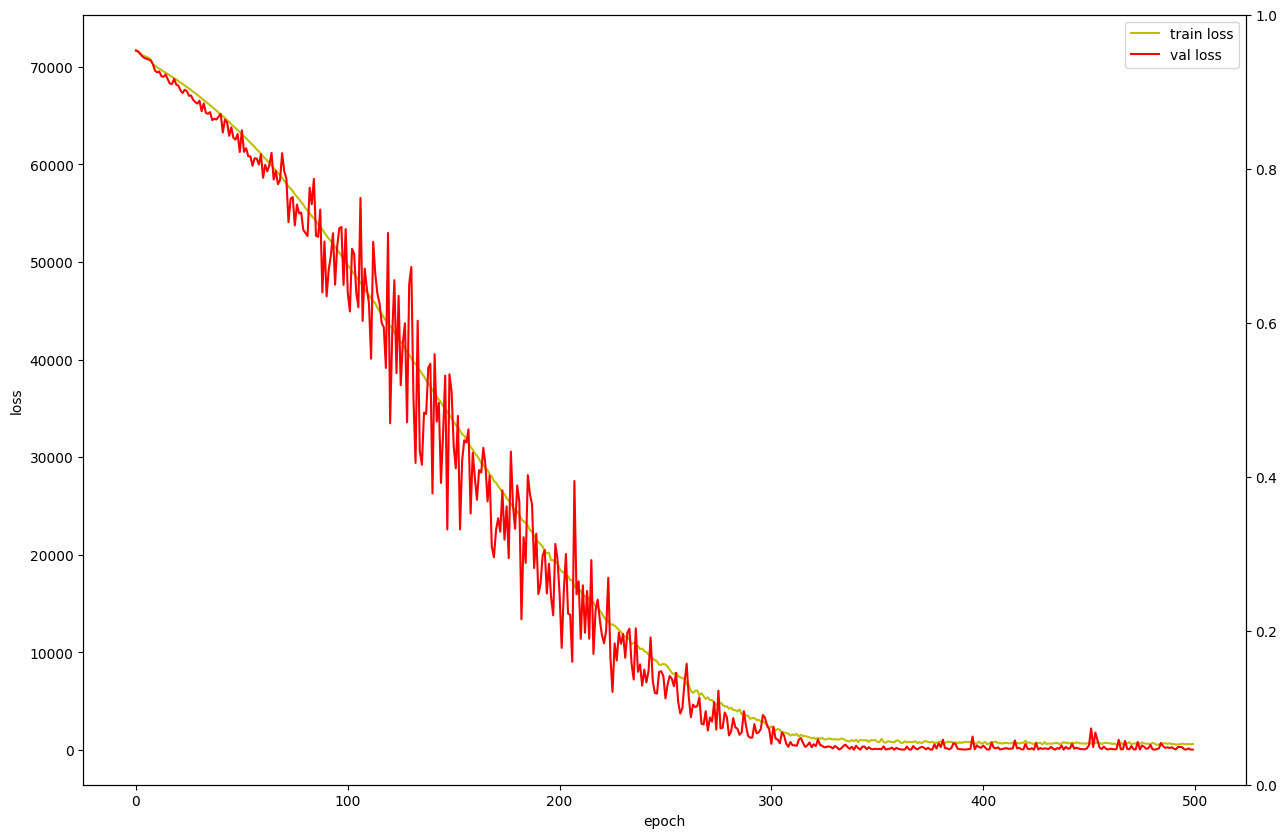

In [109]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.legend()
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

plt.show()

## 결정 계수(r2_score)

In [110]:
y_train_predict = model.predict(X_train)

71/71 [==============================] - 2s 4ms/step


In [111]:
print(r2_score(y_train, y_train_predict))

0.9953427905141305


In [112]:
# mean_squared_error: 잔차의 제곱의 평균 = 잔차가 큰 데이터를 더 큰 패널티를 주는 것

# √mean_squared_error: 루트를 씌워주는 이유는 제곱을 지워주기 위해서
print(math.sqrt(mean_squared_error(y_train, y_train_predict)))  # sqrt: 루트

6.439658609211823


In [113]:
# X_test으로 y_test 예측
y_test_predict = model.predict(y_test)

24/24 [==============================] - 0s 3ms/step


In [114]:
# y_test 결정 계수
print(r2_score(y_test, y_test_predict))

0.9963891004327105


In [115]:
# mean_squared_error: 잔차의 제곱의 평균 = 잔차가 큰 데이터를 더 큰 패널티를 주는 것

# √mean_squared_error: 루트를 씌워주는 이유는 제곱을 지워주기 위해서
print(math.sqrt(mean_squared_error(y_test, y_test_predict)))  # sqrt: 루트

5.878112095627381


## 예측

In [117]:
# 1월 30일의 Close 값
test_list = [400.59]

In [118]:
test_array = np.array(test_list)

In [119]:
model.predict(test_array.reshape(1, test_array.shape[0], 1))

1/1 [==============================] - 1s 1s/step


array([[411.34763]], dtype=float32)

실제값: 410.80

## 실제값과 예측값 시각화

In [122]:
# 전체 데이터 (11년 1월 ~ 22년 11월) 예측
visual_predict = model.predict(X.reshape(3018, 1, 1))

95/95 [==============================] - 0s 4ms/step


In [123]:
# 컬럼명이 Close인 빈 데이터 프레임 만들기
# visual_y: 예측값을 넣을 데이터 프레임
visual_y = pd.DataFrame(columns = ['Close'])

In [124]:
# 예측값을 visual_y 데이터 프레임에 넣어주기
for i in range(len(visual_predict.reshape(-1))) :
    visual_y.loc[i] = visual_predict.reshape(-1)[i]

In [125]:
visual_y

,Close
0,129.258728
1,129.086273
2,130.663742
3,130.079025
4,129.478577
...,...
3013,396.428711
3014,390.527252
3015,392.884155
3016,391.260651


In [127]:
# 빈 데이터 프레임 만들기
# visual_t: 실제값을 넣을 데이터 프레임
visual_t = df_day

In [132]:
# visual_y에 Date 붙여주기
visual_y = pd.concat([visual_y, visual_t.reset_index()['Date']], axis = 1)

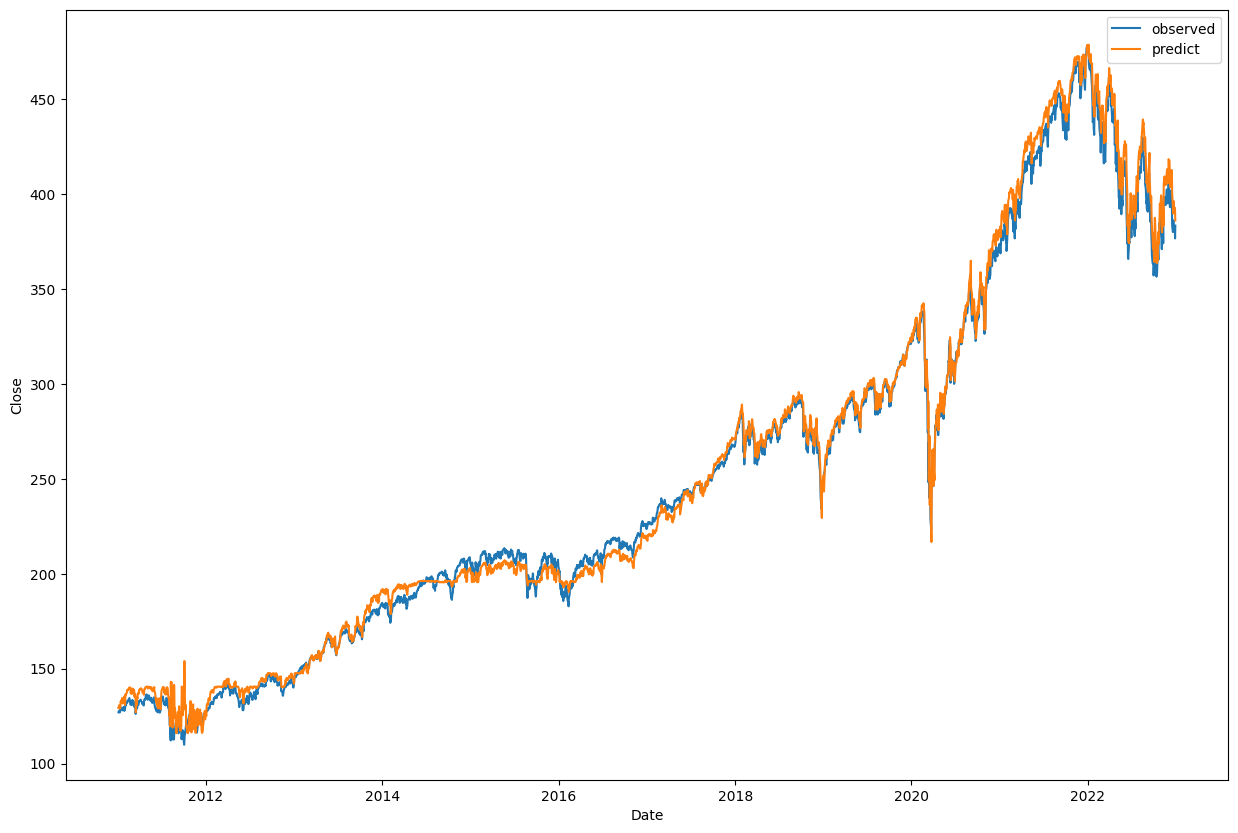

In [133]:
sns.lineplot(visual_t, x = 'Date', y = 'Close', label='observed')
sns.lineplot(visual_y, x = 'Date', y = 'Close', label='predict')
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()

# 주 별 예측

In [136]:
df_week = pd.DataFrame()

In [137]:
for i in range(len(df)) :
    if (i % 5 == 0) & (i != 0) :
        df_week = pd.concat([df_week, pd.DataFrame(df.iloc[i, :]).T])

In [138]:
df_week.set_index('Date', inplace=True)

In [139]:
x_list = []

In [140]:
for i in range(len(df)) :
    if (i % 5 == 0) & (i != 0) :
        x_list.append(df['Close'].values[i - 5:i])

In [141]:
X = np.array(x_list)

In [142]:
y_list = []

In [143]:
# 매 월 첫 날의 데이터들을 y_list에 넣어준다.
for i in range(len(df_week['Close'].tolist())) :
    y_list.append(np.array([df_week['Close'].tolist()[i]]))

In [144]:
y = np.array(y_list)

## 주 별 LSTM

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [146]:
x = layers.Input(shape=(X_train.shape[1], 1))
lstm = layers.LSTM(64)(x)
dense = layers.Dense(32)(lstm)
norm = layers.BatchNormalization()(dense)
relu = layers.ReLU()(norm)
y = layers.Dense(1)(relu)
model = models.Model(x, y)

model.compile('adam', 'mean_squared_error')  # loss function: mean_squared_error 사용

In [147]:
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=70)

In [148]:
# 모델 학습
history = model.fit(X_train, y_train, epochs = 200, validation_data = [X_test, y_test], batch_size = 16, verbose = 1)

Epoch 1/200
29/29 [==============================] - 5s 44ms/step - loss: 70829.5625 - val_loss: 72475.9062
Epoch 2/200
29/29 [==============================] - 0s 9ms/step - loss: 70251.7891 - val_loss: 72267.2266
Epoch 3/200
29/29 [==============================] - 0s 9ms/step - loss: 69881.8438 - val_loss: 71992.5859
Epoch 4/200
29/29 [==============================] - 0s 8ms/step - loss: 69503.5391 - val_loss: 71680.3984
Epoch 5/200
29/29 [==============================] - 0s 10ms/step - loss: 69061.1094 - val_loss: 70772.6797
Epoch 6/200
29/29 [==============================] - 0s 10ms/step - loss: 68379.3203 - val_loss: 70200.8047
Epoch 7/200
29/29 [==============================] - 0s 9ms/step - loss: 67589.5625 - val_loss: 69847.2812
Epoch 8/200
29/29 [==============================] - 0s 8ms/step - loss: 66896.6406 - val_loss: 69322.2422
Epoch 9/200
29/29 [==============================] - 0s 7ms/step - loss: 66182.3906 - val_loss: 67877.6328
Epoch 10/200
29/29 [==============

29/29 [==============================] - 0s 7ms/step - loss: 4138.9043 - val_loss: 13239.2148
Epoch 78/200
29/29 [==============================] - 0s 8ms/step - loss: 3100.1619 - val_loss: 8240.1514
Epoch 79/200
29/29 [==============================] - 0s 8ms/step - loss: 2899.4441 - val_loss: 6948.5264
Epoch 80/200
29/29 [==============================] - 0s 8ms/step - loss: 3474.8655 - val_loss: 2109.0808
Epoch 81/200
29/29 [==============================] - 0s 10ms/step - loss: 2721.0537 - val_loss: 11320.1631
Epoch 82/200
29/29 [==============================] - 1s 18ms/step - loss: 2904.6777 - val_loss: 563.7010
Epoch 83/200
29/29 [==============================] - 0s 8ms/step - loss: 2133.3464 - val_loss: 1231.1401
Epoch 84/200
29/29 [==============================] - 0s 9ms/step - loss: 2141.3298 - val_loss: 1023.0854
Epoch 85/200
29/29 [==============================] - 0s 8ms/step - loss: 1810.5928 - val_loss: 809.5682
Epoch 86/200
29/29 [==============================] - 0s 

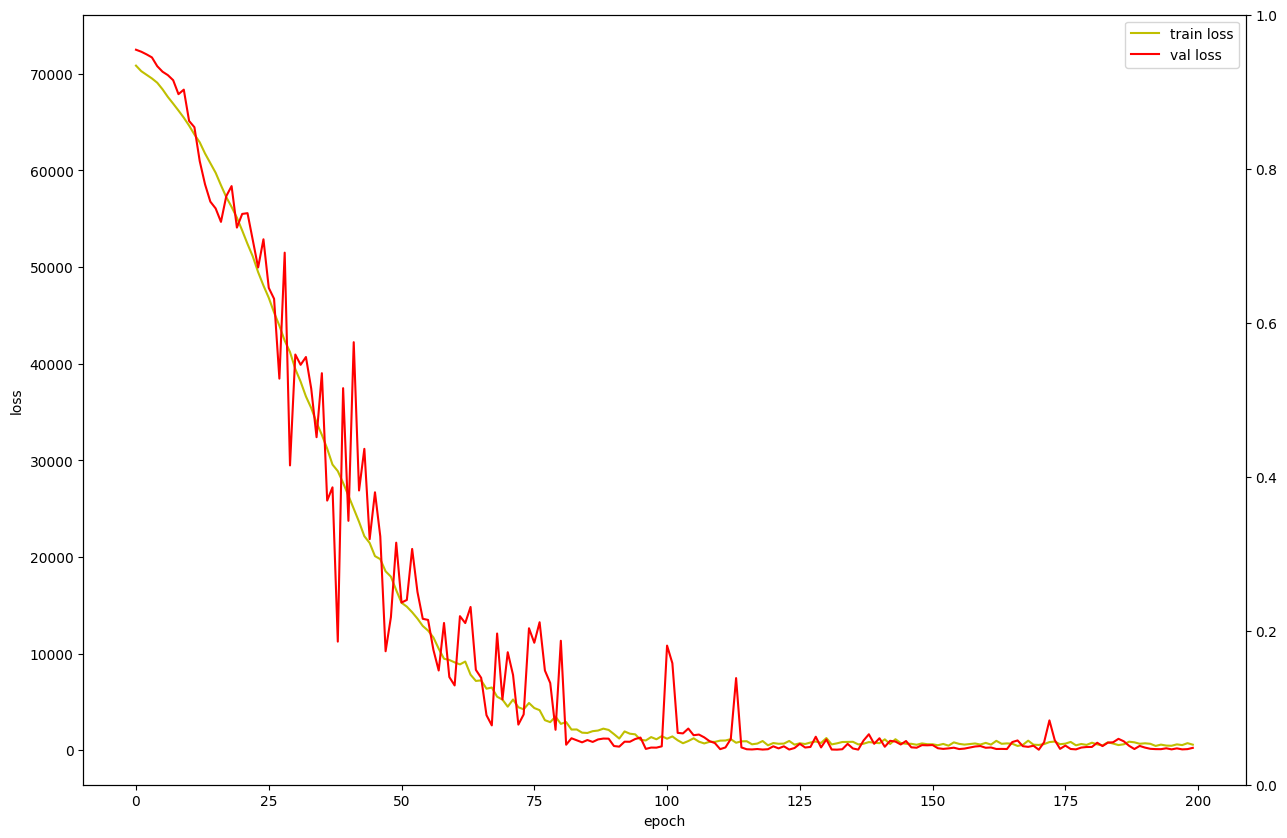

In [149]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.legend()
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

plt.show()

In [150]:
y_train_predict = model.predict(X_train)

15/15 [==============================] - 1s 3ms/step


In [151]:
print(r2_score(y_train, y_train_predict))

0.9756797869901698


In [152]:
y_test_predict = model.predict(X_test)

5/5 [==============================] - 0s 4ms/step


In [153]:
print(r2_score(y_test, y_test_predict))

0.9775920635154894


## 예측

In [154]:
# 2023년 1월의 마지막 5일 종가 데이터
test_list = [400.20, 400.35, 404.75, 405.68, 400.59]

In [155]:
test_array = np.array(test_list)

In [156]:
# 2023년 2월 1일의 종가 예측
print(model.predict(test_array.reshape(1, test_array.shape[0], 1)))

1/1 [==============================] - 1s 563ms/step
[[377.04114]]


실제값: 410.80

## 실제값과 예측값 시각화

In [157]:
len(X)

603

In [158]:
visual_predict = model.predict(X.reshape(603, 5, 1))

19/19 [==============================] - 0s 4ms/step


In [159]:
visual_t = df_y.reset_index()

In [160]:
visual_y = pd.concat([visual_t['Date'], pd.DataFrame(visual_predict)], axis = 1)
visual_y.rename({0 : 'Close'}, axis = 'columns', inplace = True)
visual_y

,Date,Close
0,2011-01-10,132.644867
1,2011-01-18,134.272186
2,2011-01-25,134.120850
3,2011-02-01,133.849854
4,2011-02-08,136.148788
...,...,...
598,2022-11-25,378.890503
599,2022-12-02,384.382050
600,2022-12-09,371.944672
601,2022-12-16,364.723328


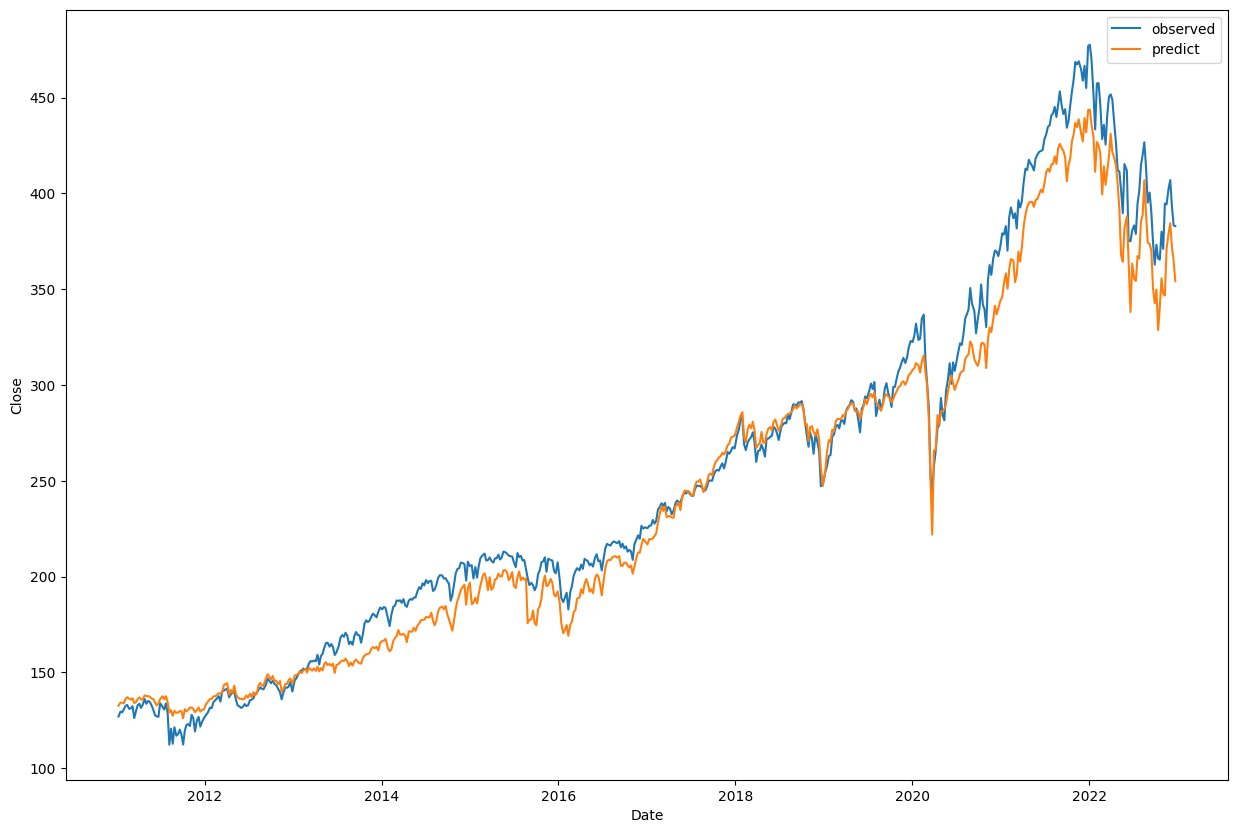

In [161]:
sns.lineplot(visual_t, x = 'Date', y = 'Close', label='observed')
sns.lineplot(visual_y, x = 'Date', y = 'Close', label='predict')
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()